In [1]:
!pip install torch torchvision torchaudio
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Check CUDA version
!nvidia-smi

# Install PyTorch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# If detectron2 folder exist remove it
!rm -rf detectron2

# Clone Detectron2
!git clone https://github.com/facebookresearch/detectron2.git

# Change directory to the Detectron2 root
import os
os.chdir("detectron2")

# Install Detectron2
!pip install -e .

Fri Mar 21 09:38:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from google.colab import drive

In [2]:
import os
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/brain_tumor_detection'
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


In [3]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

print("Path to dataset files:", dataset_path)

100%|██████████| 84.0M/84.0M [00:03<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12


In [4]:
print(os.listdir(dataset_path))

['Br35H-Mask-RCNN', 'pred', 'no', 'yes']


**Transforming to COCO-Format**

In [5]:
import json
import math
from PIL import Image

train_images_path = os.path.join(dataset_path, "Br35H-Mask-RCNN/TRAIN")
valid_images_path = os.path.join(dataset_path, "Br35H-Mask-RCNN/VAL")

train_annotations_path = os.path.join(dataset_path, "Br35H-Mask-RCNN/TRAIN/annotations_train.json")
valid_annotations_path = os.path.join(dataset_path, "Br35H-Mask-RCNN/VAL/annotations_val.json")

with open(train_annotations_path, 'r') as f:
    train_annotations = json.load(f)

with open(valid_annotations_path, 'r') as f:
    valid_annotations = json.load(f)

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

def approximate_ellipse(cx, cy, rx, ry, num_points=20):
    """Generate points approximating an ellipse for segmentation."""
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        x = cx + rx * math.cos(angle)
        y = cy + ry * math.sin(angle)
        points.extend([x, y])  # Flattened format
    return [points]  # COCO expects a list of lists for segmentation

def create_coco_annotations(annotations, dataset_type):
    coco_dataset = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 0, "name": "tumor", "supercategory": "none"}]
    }

    image_id = 1
    annotation_id = 1

    for filename, data in annotations.items():
        image_path = os.path.join(dataset_path, "Br35H-Mask-RCNN", "TRAIN" if dataset_type == "train" else "VAL", data['filename'])

        width, height = get_image_size(image_path)

        image_info = {
            "id": image_id,
            "file_name": data['filename'],
            "height": height,
            "width": width,
        }
        coco_dataset["images"].append(image_info)

        if 'regions' not in data or not data['regions']:
            print(f"Warning: No regions found for image {data['filename']}. Skipping.")
            continue

        for region in data['regions']:
            if 'shape_attributes' in region:
                sa = region['shape_attributes']
                points_x = sa.get('all_points_x', [])
                points_y = sa.get('all_points_y', [])
                cx, cy, rx, ry = sa.get('cx'), sa.get('cy'), sa.get('rx'), sa.get('ry')

                if points_x and points_y:
                    # Polygon
                    segmentation = [[coord for point in zip(points_x, points_y) for coord in point]]
                    min_x = min(points_x)
                    min_y = min(points_y)
                    max_x = max(points_x)
                    max_y = max(points_y)
                    bbox = [min_x, min_y, max_x - min_x, max_y - min_y]

                elif cx is not None and cy is not None and rx is not None and ry is not None:
                    # Ellipse approximated as polygon
                    segmentation = approximate_ellipse(cx, cy, rx, ry)
                    bbox = [cx - rx, cy - ry, 2 * rx, 2 * ry]

                else:
                    print(f"Warning: Invalid region for image {data['filename']}. Skipping.")
                    continue

                annotation_info = {
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": 0,  # "tumor" class
                    "segmentation": segmentation,
                    "area": bbox[2] * bbox[3],  # Width * Height
                    "iscrowd": 0,
                    "bbox": bbox
                }
                coco_dataset["annotations"].append(annotation_info)
                annotation_id += 1

        image_id += 1

    output_json_path = f"/content/drive/MyDrive/brain_tumor_detection/brain_tumor_{dataset_type}_coco_format.json"

    with open(output_json_path, 'w') as f:
        json.dump(coco_dataset, f)

    print(f"COCO format {dataset_type} annotations saved to {output_json_path}")

create_coco_annotations(train_annotations, "train")
create_coco_annotations(valid_annotations, "valid")

COCO format train annotations saved to /content/drive/MyDrive/brain_tumor_detection/brain_tumor_train_coco_format.json
COCO format valid annotations saved to /content/drive/MyDrive/brain_tumor_detection/brain_tumor_valid_coco_format.json


In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

train_json = '/content/drive/MyDrive/brain_tumor_detection/brain_tumor_train_coco_format.json'
train_images = '/root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12/Br35H-Mask-RCNN/TRAIN'
valid_json = '/content/drive/MyDrive/brain_tumor_detection/brain_tumor_valid_coco_format.json'
valid_images = '/root/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12/Br35H-Mask-RCNN/VAL'


register_coco_instances("train_data", {}, train_json, train_images)
register_coco_instances("valid_data", {}, valid_json, valid_images)

print("Dataset enregistré dans Detectron2.")

Dataset enregistré dans Detectron2.


In [7]:
import urllib.request

config_filename_1 = "mask_rcnn_R_50_FPN.yaml"
config_filename_2 = "Base-RCNN-FPN.yaml"

# Paths where the config files will be stored
config_path_1 = os.path.join('/content/drive/MyDrive', 'detectron2', 'tools', 'configs', 'COCO-Detection', config_filename_1)
config_path_2 = os.path.join('/content/drive/MyDrive', 'detectron2', 'tools', 'configs', config_filename_2)

# URLs for the raw config files
download_url_1 = "https://raw.githubusercontent.com/facebookresearch/detectron2/9604f5995cc628619f0e4fd913453b4d7d61db3f/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml"
download_url_2 = "https://raw.githubusercontent.com/facebookresearch/detectron2/9604f5995cc628619f0e4fd913453b4d7d61db3f/configs/Base-RCNN-FPN.yaml"

# Function to download the file if it doesn't exist
def download_config(config_path, download_url):
    if not os.path.isfile(config_path):
        print(f"{os.path.basename(config_path)} introuvable dans {config_path}. Téléchargement en cours...")
        try:
            # Create the directories
            os.makedirs(os.path.dirname(config_path), exist_ok=True)
            # Download the file
            urllib.request.urlretrieve(download_url, config_path)
            print(f"{os.path.basename(config_path)} téléchargé avec succès.")
        except Exception as e:
            print(f"Erreur lors du téléchargement : {e}")
    else:
        print(f"{os.path.basename(config_path)} est déjà présent dans le répertoire {config_path}.")

# Download both config files
download_config(config_path_1, download_url_1)
download_config(config_path_2, download_url_2)

# Import the config module and load the configuration files
from detectron2.config import get_cfg

cfg = get_cfg()

# Merge the configuration files
cfg.merge_from_file(config_path_1)
cfg.merge_from_file(config_path_2)

print("Done")

mask_rcnn_R_50_FPN.yaml introuvable dans /content/drive/MyDrive/detectron2/tools/configs/COCO-Detection/mask_rcnn_R_50_FPN.yaml. Téléchargement en cours...
mask_rcnn_R_50_FPN.yaml téléchargé avec succès.
Base-RCNN-FPN.yaml introuvable dans /content/drive/MyDrive/detectron2/tools/configs/Base-RCNN-FPN.yaml. Téléchargement en cours...
Base-RCNN-FPN.yaml téléchargé avec succès.
Done


[03/21 09:44:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 110MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/21 09:44:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/21 09:44:42 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/21 09:45:08 d2.utils.events]:  eta: 0:59:42  iter: 19  total_loss: 1.828  loss_cls: 0.759  loss_box_reg: 0.363  loss_mask: 0.693  loss_rpn_cls: 0.02077  loss_rpn_loc: 0.006523    time: 1.1769  last_time: 1.3489  data_time: 0.0426  last_data_time: 0.0272   lr: 7.2025e-07  max_mem: 6594M
[03/21 09:45:44 d2.utils.events]:  eta: 1:01:07  iter: 39  total_loss: 1.845  loss_cls: 0.7394  loss_box_reg: 0.3839  loss_mask: 0.6922  loss_rpn_cls: 0.02216  loss_rpn_loc: 0.007384    time: 1.2292  last_time: 1.4660  data_time: 0.0425  last_data_time: 0.0862   lr: 1.2152e-06  max_mem: 6594M
[03/21 09:46:10 d2.utils.events]:  eta: 1:01:30  iter: 59  total_loss: 1.813  loss_cls: 0.7254  loss_box_reg: 0.3684  loss_mask: 0.6906  loss_rpn_cls: 0.02058  loss_rpn_loc: 0.008063    time: 1.2496  last_time: 1.4432  data_time: 0.0276  last_data_time: 0.0308   lr: 1.7103e-06  max_mem: 6594M
[03/21 09:46:34 d2.utils.events]:  eta: 1:01:05  iter: 79  total_loss: 1.809  loss_cls: 0.6889  loss_box_reg: 0.3928  los

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[03/21 10:47:24 d2.engine.train_loop]: Starting training from iteration 0
[03/21 10:47:50 d2.utils.events]:  eta: 1:03:36  iter: 19  total_loss: 1.634  loss_cls: 0.5487  loss_box_reg: 0.3679  loss_mask: 0.6953  loss_rpn_cls: 0.01521  loss_rpn_loc: 0.006935    time: 1.2668  last_time: 1.2861  data_time: 0.0499  last_data_time: 0.0425   lr: 7.2025e-07  max_mem: 6594M
[03/21 10:48:15 d2.utils.events]:  eta: 1:02:59  iter: 39  total_loss: 1.662  loss_cls: 0.5471  loss_box_reg: 0.392  loss_mask: 0.6945  loss_rpn_cls: 0.0244  loss_rpn_loc: 0.006414    time: 1.2693  last_time: 1.1626  data_time: 0.0382  last_data_time: 0.0249   lr: 1.2152e-06  max_mem: 6594M
[03/21 10:48:40 d2.utils.events]:  eta: 1:02:29  iter: 59  total_loss: 1.602  loss_cls: 0.5278  loss_box_reg: 0.3691  loss_mask: 0.6926  loss_rpn_cls: 0.02346  loss_rpn_loc: 0.008796    time: 1.2684  last_time: 1.3617  data_time: 0.0360  last_data_time: 0.0249   lr: 1.7103e-06  max_mem: 6594M
[03/21 10:49:06 d2.utils.events]:  eta: 1:02:0

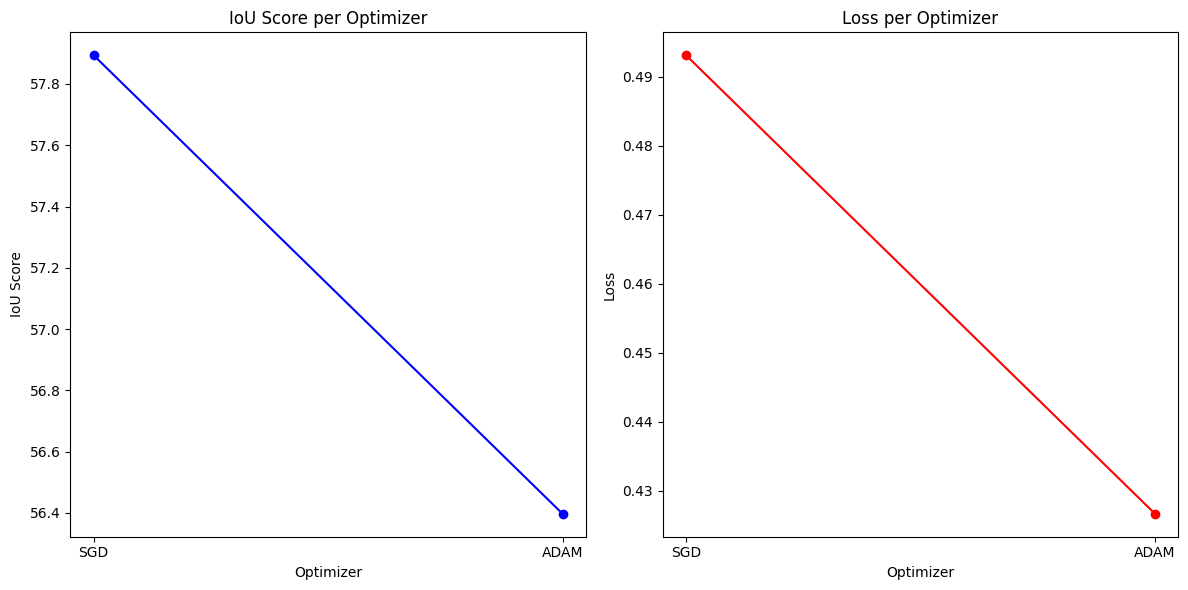

In [8]:
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger

setup_logger()

# configure Detectron2
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/detectron2/tools/configs/COCO-Detection/mask_rcnn_R_50_FPN.yaml")

# datasets
cfg.DATASETS.TRAIN = ("train_data",)
cfg.DATASETS.TEST = ("valid_data",)
cfg.DATALOADER.NUM_WORKERS = 2

# Pre-trained weights
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

# optimizer: SGD with momentum
cfg.SOLVER.OPTIMIZER = "SGD"
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
cfg.SOLVER.STEPS = (1000, 2000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.MAX_ITER = 3000

# Hyperparameters for training
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only "tumor" class
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Score threshold for object detection

# Set output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/detectron2/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

evaluator = COCOEvaluator("valid_data", output_dir=cfg.OUTPUT_DIR, distributed=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

optimizers = ['SGD', 'ADAM']
metrics = {'IoU': [], 'Loss': []}

for optimizer in optimizers:
    if optimizer == "SGD":
        cfg.SOLVER.OPTIMIZER = "SGD"
        cfg.SOLVER.MOMENTUM = 0.9
    elif optimizer == "ADAM":
        cfg.SOLVER.OPTIMIZER = "ADAM"
        cfg.SOLVER.ADAM_BETA1 = 0.9
        cfg.SOLVER.ADAM_BETA2 = 0.999
        cfg.SOLVER.ADAM_EPSILON = 1e-08

    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()

    evaluator = COCOEvaluator("valid_data", output_dir=cfg.OUTPUT_DIR, distributed=True)

    results = trainer.test(cfg, trainer.model, evaluators=[evaluator])
    metrics['IoU'].append(results["bbox"]["AP"])

    loss_history = trainer.storage.history("total_loss").values()
    last_loss = loss_history[-1][0] if loss_history else None
    metrics['Loss'].append(last_loss)


def plot_metrics(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(optimizers, metrics['IoU'], marker='o', color='b')
    ax1.set_title('IoU Score per Optimizer')
    ax1.set_xlabel('Optimizer')
    ax1.set_ylabel('IoU Score')

    ax2.plot(optimizers, metrics['Loss'], marker='o', color='r')
    ax2.set_title('Loss per Optimizer')
    ax2.set_xlabel('Optimizer')
    ax2.set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

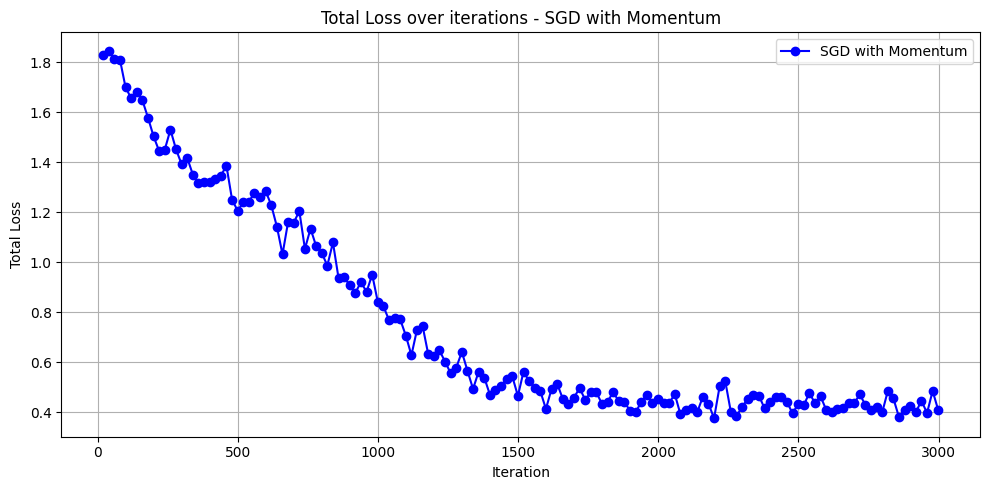

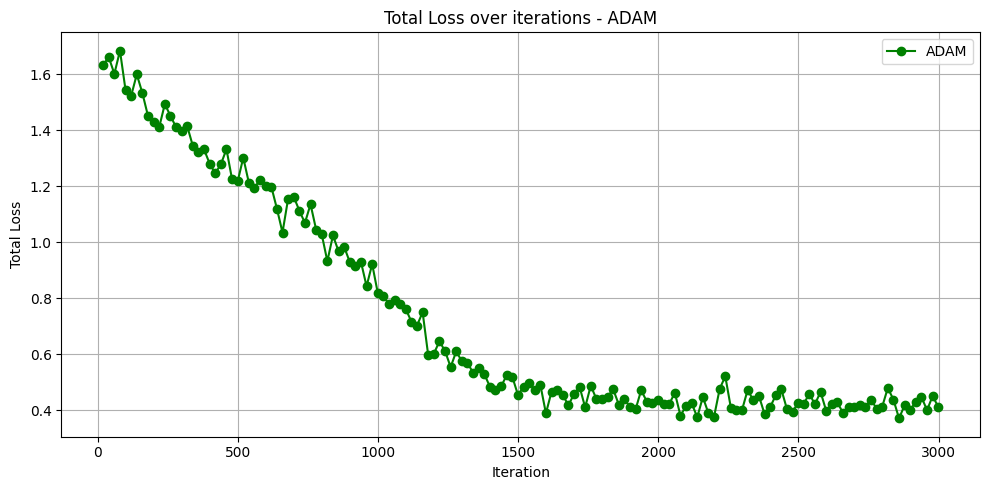

In [31]:
from tensorboard.backend.event_processing import event_accumulator

log_dir = "/content/drive/MyDrive/detectron2"

sgd_file = os.path.join(log_dir, "events.out.tfevents.1742550319.5185bdcd95ee.2366.0")
adam_file = os.path.join(log_dir, "events.out.tfevents.1742554070.5185bdcd95ee.2366.1")

loss_data = {}

for file_path, label in zip([sgd_file, adam_file], ["SGD with Momentum", "ADAM"]):
    ea = event_accumulator.EventAccumulator(file_path)
    ea.Reload()

    if 'total_loss' not in ea.Tags()['scalars']:
        print(f"No 'total_loss' in {file_path}, skipping.")
        continue

    events = ea.Scalars('total_loss')
    steps = [e.step for e in events]
    losses = [e.value for e in events]

    loss_data[label] = (steps, losses)

for label, (steps, losses) in loss_data.items():
    plt.figure(figsize=(10, 5))
    plt.plot(steps, losses, marker='o', linestyle='-', label=label, color='blue' if label == 'SGD with Momentum' else 'green')
    plt.title(f'Total Loss over iterations - {label}')
    plt.xlabel('Iteration')
    plt.ylabel('Total Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

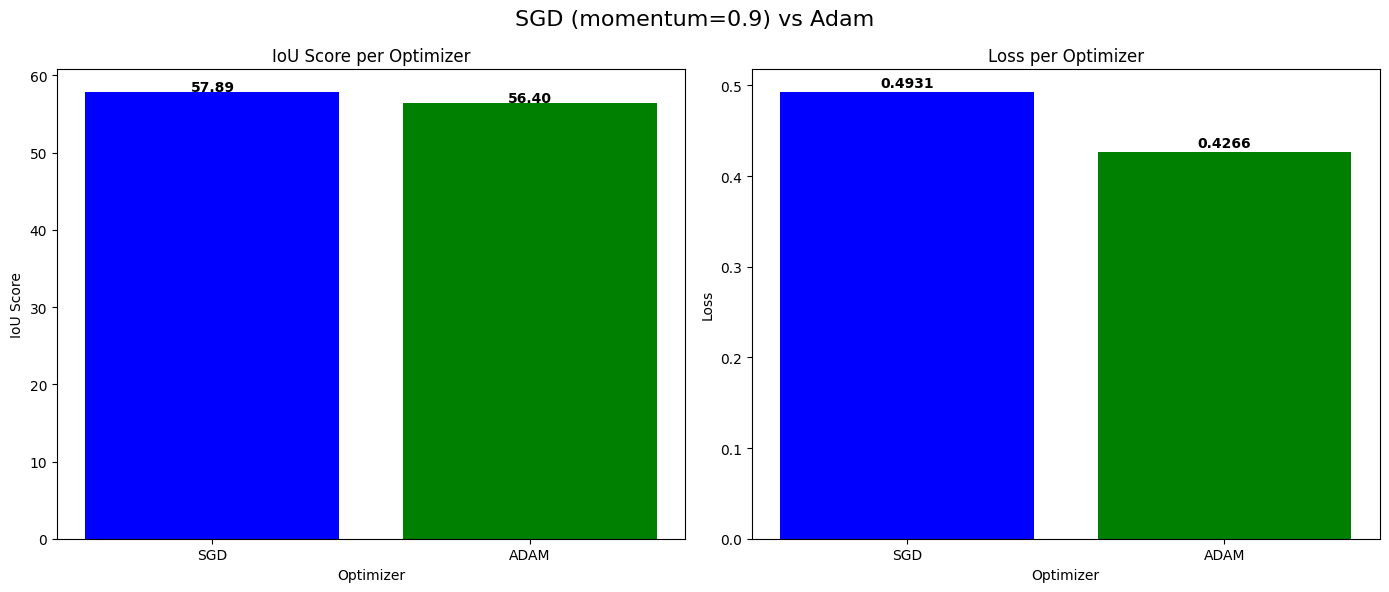

In [32]:
import matplotlib.pyplot as plt

def plot_optimizer_comparison(metrics, optimizers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # IoU
    ax1.bar(optimizers, metrics['IoU'], color=['blue', 'green'])
    for i, v in enumerate(metrics['IoU']):
        ax1.text(i, v + 0.1, f"{v:.2f}", ha='center', fontweight='bold')
    ax1.set_title('IoU Score per Optimizer')
    ax1.set_xlabel('Optimizer')
    ax1.set_ylabel('IoU Score')

    # Loss
    ax2.bar(optimizers, metrics['Loss'], color=['blue', 'green'])
    for i, v in enumerate(metrics['Loss']):
        ax2.text(i, v + 0.005, f"{v:.4f}", ha='center', fontweight='bold')
    ax2.set_title('Loss per Optimizer')
    ax2.set_xlabel('Optimizer')
    ax2.set_ylabel('Loss')

    plt.suptitle('SGD (momentum=0.9) vs Adam', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_optimizer_comparison(metrics, optimizers)

In [17]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.8 MB/s eta 0:00:00


In [20]:
import gradio as gr
from detectron2.utils.visualizer import Visualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Detectron2 model
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/detectron2/tools/configs/COCO-Detection/mask_rcnn_R_50_FPN.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/detectron2/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load predictor
predictor = DefaultPredictor(cfg)

MetadataCatalog.get("tumor_data").thing_classes = ["tumor"]
metadata = MetadataCatalog.get("tumor_data")

def predict(image):
    # from RGB (Gradio) to BGR (OpenCV)
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    outputs = predictor(image_bgr)
    v = Visualizer(image_bgr[:, :, ::-1], metadata=metadata, scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    annotated_img = out.get_image()[:, :, ::-1]  # back to RGB
    return annotated_img


app = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="Upload an Image"),
    outputs=gr.Image(type="numpy", label="Brain Tumor Detection"),
    title="Brain Tumor Detection using Detectron2",
    description="Upload an image. The Mask R-CNN model will detect and annotate brain tumors."
)

app.launch()

[03/21 12:29:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/detectron2/model_final.pth ...
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4d75357354aec443db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
